# CNN mini-Project Pytorch

**keywords:** Pytorch, CNN, cyclic learning rate, one cycle learning rate, SGD, Adam, transfer learning, ResNet34

In this mini-Project we will try an architecture like VGG16, ResNet9 and ResNet34 with transfer learning. The goal is to classify 10 classes of imagies (taken from Imagenet).

Main sources:
*    [fast.ai (Jeremy Howard)](https://www.fast.ai/)
*   [fast.ai datasets](https://course.fast.ai/datasets)
*   [Deep Learning with PyTorch: Zero to GANs](https://jovian.ml/forum/t/start-here-welcome-to-deep-learning-with-pytorch-zero-to-gans/1622)
*   [How Do You Find A Good Learning Rate by Sylvain Gugger](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
*   [Adaptive - and Cyclical Learning Rates using PyTorch](https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee)

In [1]:
import os
import tarfile
from tqdm.notebook import tqdm

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.datasets.utils import download_url
from torchvision import datasets, models, transforms

## Dataset wtih 10 classes from Imagenet

A subset of 10 easily classified classes from Imagenet: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute.

The dataset is from [fast.ai datasets](https://course.fast.ai/datasets), each image is RGB 160x160 px.

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./imagenette-160.tgz


In [3]:
# Extract from archive
with tarfile.open('./imagenette-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [2]:
data_dir = './data/imagenette-160'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'val']
['n03000684', 'n02979186', 'n03417042', 'n03028079', 'n03888257', 'n03394916', 'n03445777', 'n02102040', 'n03425413', 'n01440764']


The dataset is balanced as we see bellow the observations for each class in train and validation set.

In [6]:
print("train set",[len(os.listdir(data_dir + "/train/"+ cls)) for cls in classes])
print("validation set",[len(os.listdir(data_dir + "/val/"+ cls)) for cls in classes])

train set [1194, 1300, 1300, 1300, 1300, 1300, 1300, 1300, 1300, 1300]
validation set [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


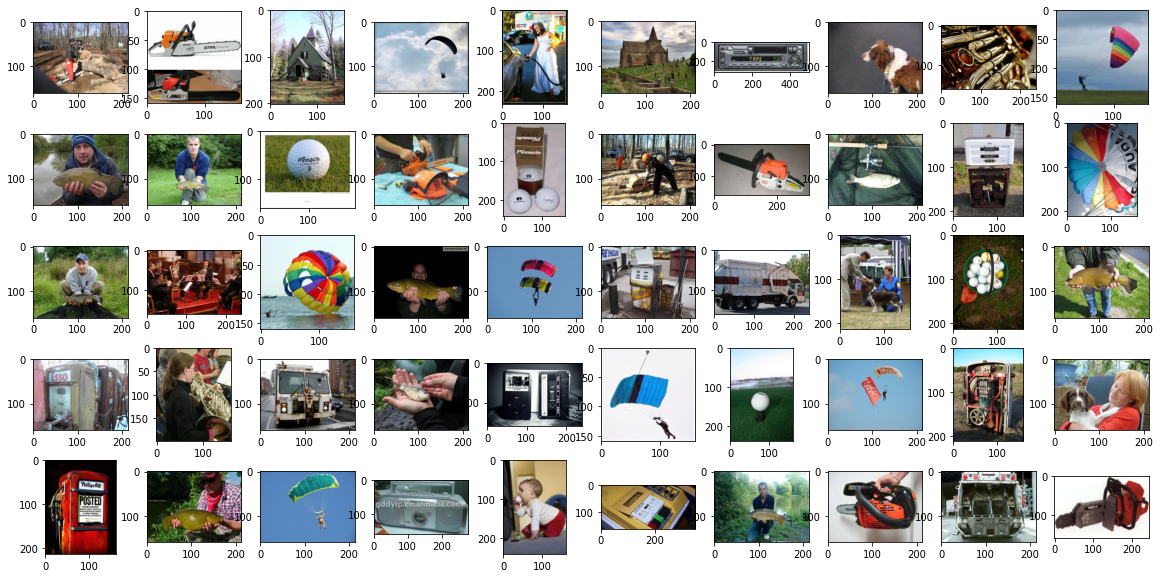

In [ ]:
def plot_grid(data_display):
    fig, ax = plt.subplots(5,10,figsize=(20,10))
    pic = np.random.choice(range(500), 50, replace=False)
    i = 0
    for n in range(5):
        for m in range(10):
            img, _  = data_display[pic[i]]
            i += 1
            ax[n,m].imshow(img.permute(1, 2, 0))
            ax[n,m].grid(False)
            
data_display = datasets.ImageFolder(data_dir+'/val', transform=transforms.ToTensor())
plot_grid(data_display)

## Preprocessing

Let's find the mean and std for each channel (RBG) of the train images.

In [ ]:
%%time
# create the DataLoader
dataset = torchvision.datasets.ImageFolder(data_dir+'/train', 
                                           transform=transforms.Compose([
                                               transforms.Resize(size=(160,160)),
                                               transforms.ToTensor() #to [0,1]
                                           ]))

loader = torch.utils.data.DataLoader(dataset, batch_size=256)

mean = 0.
std = 0.

for images, _ in tqdm(loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(mean,std)


tensor([0.4624, 0.4574, 0.4293]) tensor([0.2327, 0.2267, 0.2352])
CPU times: user 28.3 s, sys: 921 ms, total: 29.2 s
Wall time: 29.3 s


In [3]:
stats = ([0.4624, 0.4574, 0.4293],[0.2327, 0.2267, 0.2352]) 
# Data transforms (normalization & data augmentation)
train_tfms = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.RandomCrop(160, padding=10, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30),
    transforms.ToTensor(),  #scales to [0,1] range
    transforms.Normalize(*stats,inplace=True) # to [-1,1]
    ])

valid_tfms = transforms.Compose([transforms.Resize((160,160)), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(*stats)
                                 ])

In [4]:
train_ds = datasets.ImageFolder(data_dir+'/train', transform=train_tfms)
val_ds = datasets.ImageFolder(data_dir+'/val', transform=valid_tfms)

In [5]:
random_seed = 8
torch.manual_seed(random_seed);

In [6]:
batch_size=64  #128
train_dataloader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3)
valid_dataloader = DataLoader(val_ds, batch_size*2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


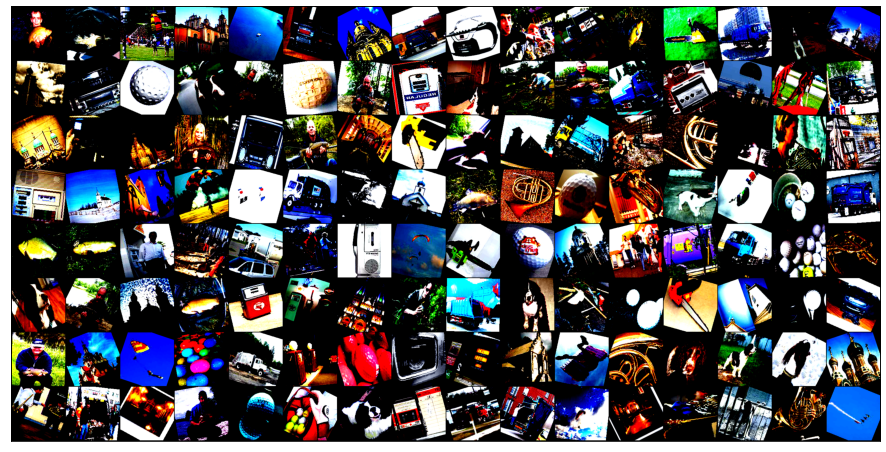

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dataloader)

We can see the augmented images and that the colors have changed because we standardizes them to have mean 0 and std 1 (the negative values are dispayed as black in the above grid). 

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device) 
        labels = labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device) 
        labels = labels.to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Model like VGG16 architecture

In [9]:
class likeVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # Define the network
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # padding SAME , padding=1
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),       
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.05))

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 20 * 20, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 10))
    
        
    def forward(self, x):    
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) 
        #print(x.shape)
        x = x.view(-1, 256 * 20 * 20)  #Flattening
        x = self.fc(x)
        return x

## Learning Rate Finder



*   [How Do You Find A Good Learning Rate by Sylvain Gugger](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
*   [Cyclical Learning Rates for Training Neural Networks, Leslie N. Smith](https://arxiv.org/abs/1506.01186)



In [10]:
# Reference: https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
def find_lr(net, optimizer, criterion,trn_loader, init_value = 1e-8, final_value=10., smoothing=0.2):
    torch.cuda.empty_cache()
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    losses = []
    log_lrs = []
    for batch in tqdm(trn_loader):
        inputs,labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()   # Zero gradients
        outputs = net(inputs)   # Get outputs to calc loss
        loss = criterion(outputs, labels)
        if not losses: 
            losses.append(loss)
        else:
            smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * losses[-1]
            losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the optimizer step
        loss.backward()  # Backward pass
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [ ]:
%%time
net = likeVGG16()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(),lr=1e-1)

logs,losses = find_lr(net, optimizer, criterion=F.cross_entropy, 
                      trn_loader=train_dataloader)


CPU times: user 1min 11s, sys: 51.1 s, total: 2min 2s
Wall time: 2min 7s


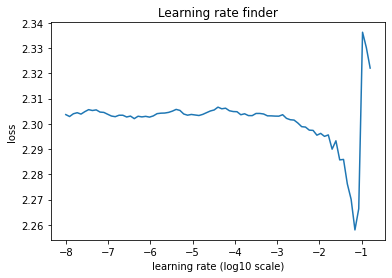

In [ ]:
plt.plot(logs[0:-20],losses[0:-20])
plt.xlabel('learning rate (log10 scale)')
plt.ylabel('loss')
plt.title('Learning rate finder');

From 1e-3 to 5e-2.

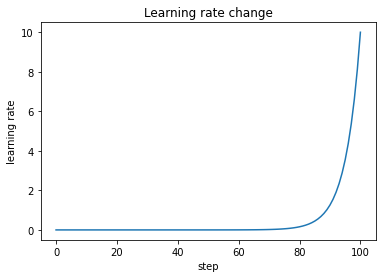

In [ ]:
plt.plot(range(len(logs)),np.power(10, logs))
plt.ylabel('learning rate')
plt.xlabel('step')
plt.title('Learning rate change');

## CyclicLR

In [59]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_cyclic(epochs, base_lr, max_lr, model, train_loader, val_loader, 
               grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up optimizer
    optimizer = opt_func(model.parameters(), base_lr)
    # Set up Cyclic learning rate scheduler
    sched = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                             base_lr=base_lr,
                                             max_lr=max_lr,
                                             step_size_up=len(train_loader)/2,
                                             step_size_down=len(train_loader)/2,
                                             mode="triangular2") 
                                             # gamma=0.8, mode="exp_range"

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
# some helper plot functions
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_learning_rates_one_epoch(history):
    lrs = history[1]['lrs']
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel('steps')
    plt.ylabel('Learning rate')
    plt.title('Learing rate in each epoch');

def plot_learning_rates(history):
    history = history[1:]
    lrs = [x['lrs'] for x in history]
    lrs = np.asarray(lrs).reshape(-1)
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel('steps')
    plt.ylabel('Learning rate')
    plt.title('Learing rate in all epochs');

In [12]:
net = likeVGG16()
net = net.to(device)
epochs = 15
base_lr = 1e-3
max_lr = lr = 7e-2
grad_clip = 0.1
opt_func = torch.optim.SGD

history = [evaluate(net, valid_dataloader)]
history

[{'val_acc': 0.09765625, 'val_loss': 2.3028669357299805}]

In [18]:
%%time
history += fit_cyclic(epochs, base_lr, max_lr, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip,  
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00237, train_loss: 1.8575, val_loss: 1.2503, val_acc: 0.5661



Epoch [1], last_lr: 0.00168, train_loss: 1.3610, val_loss: 1.0208, val_acc: 0.6434



Epoch [2], last_lr: 0.00134, train_loss: 1.1362, val_loss: 0.9039, val_acc: 0.6990



Epoch [3], last_lr: 0.00117, train_loss: 0.9921, val_loss: 0.8045, val_acc: 0.7387



Epoch [4], last_lr: 0.00109, train_loss: 0.9072, val_loss: 0.7493, val_acc: 0.7424



Epoch [5], last_lr: 0.00104, train_loss: 0.8337, val_loss: 0.7176, val_acc: 0.7640



Epoch [6], last_lr: 0.00102, train_loss: 0.7985, val_loss: 0.7055, val_acc: 0.7723



Epoch [7], last_lr: 0.00101, train_loss: 0.7674, val_loss: 0.6985, val_acc: 0.7664



Epoch [8], last_lr: 0.00101, train_loss: 0.7505, val_loss: 0.6803, val_acc: 0.7764



Epoch [9], last_lr: 0.00100, train_loss: 0.7277, val_loss: 0.6986, val_acc: 0.7643



Epoch [10], last_lr: 0.00100, train_loss: 0.7076, val_loss: 0.6744, val_acc: 0.7824



Epoch [11], last_lr: 0.00100, train_loss: 0.6922, val_loss: 0.6561, val_acc: 0.7945



Epoch [12], last_lr: 0.00100, train_loss: 0.6806, val_loss: 0.6498, val_acc: 0.8083



Epoch [13], last_lr: 0.00100, train_loss: 0.6647, val_loss: 0.6637, val_acc: 0.7784



Epoch [14], last_lr: 0.00100, train_loss: 0.6490, val_loss: 0.6333, val_acc: 0.8019
CPU times: user 17min 31s, sys: 12min 12s, total: 29min 43s
Wall time: 30min 48s


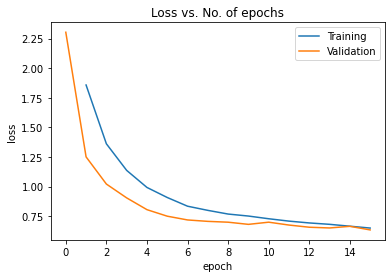

In [20]:
plot_losses(history)

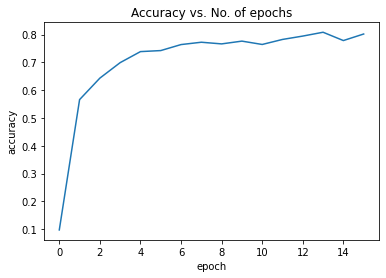

In [21]:
plot_accuracies(history)

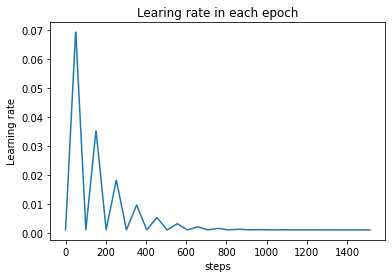

In [23]:
plot_learning_rates(history)

## One cycle with Adam

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
net = likeVGG16()
net = net.to(device)
epochs = 10
max_lr = lr = 1e-3 
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

history = [evaluate(net, valid_dataloader)]
history

[{'val_acc': 0.09765625, 'val_loss': 2.303180694580078}]

In [18]:
%%time
history += fit_one_cycle(epochs, max_lr, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00028, train_loss: 1.6529, val_loss: 1.2640, val_acc: 0.5701



Epoch [1], last_lr: 0.00076, train_loss: 1.3039, val_loss: 1.3354, val_acc: 0.5611



Epoch [2], last_lr: 0.00100, train_loss: 1.2153, val_loss: 0.8919, val_acc: 0.7005



Epoch [3], last_lr: 0.00095, train_loss: 1.0781, val_loss: 0.8714, val_acc: 0.6989



Epoch [4], last_lr: 0.00081, train_loss: 0.9577, val_loss: 0.7169, val_acc: 0.7715



Epoch [5], last_lr: 0.00061, train_loss: 0.8486, val_loss: 0.6614, val_acc: 0.7855



Epoch [6], last_lr: 0.00039, train_loss: 0.7534, val_loss: 0.6671, val_acc: 0.7926



Epoch [7], last_lr: 0.00019, train_loss: 0.6176, val_loss: 0.5535, val_acc: 0.8360



Epoch [8], last_lr: 0.00005, train_loss: 0.5308, val_loss: 0.5364, val_acc: 0.8399



Epoch [9], last_lr: 0.00000, train_loss: 0.4738, val_loss: 0.5303, val_acc: 0.8501
CPU times: user 15min 25s, sys: 11min 6s, total: 26min 32s
Wall time: 27min 12s


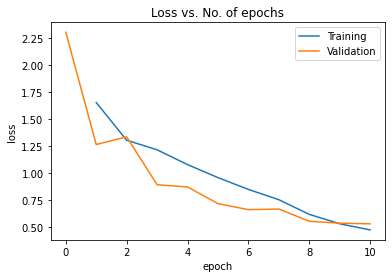

In [19]:
plot_losses(history)

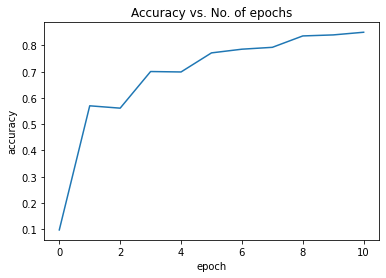

In [20]:
plot_accuracies(history)

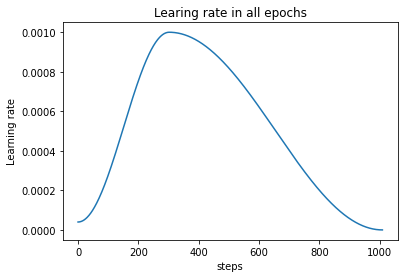

In [26]:
plot_learning_rates(history)

In [ ]:
%%time
history += fit_one_cycle(4, 6e-4, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

# ResNet9 Model

In [47]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512*5*5, 10))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out  #res layer
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out  #res layer
        #print(out.shape)
        out = self.classifier(out)
        return out

## One cycle with Adam

In [69]:
net2 = ResNet9()
net2 = net2.to(device)
epochs = 8
max_lr = lr = 1e-3 
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history = [evaluate(net2, valid_dataloader)]
history

[{'val_acc': 0.095703125, 'val_loss': 2.3027286529541016}]

In [70]:
%%time
history += fit_one_cycle(epochs, max_lr, net2, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00039, train_loss: 1.6464, val_loss: 2.0521, val_acc: 0.4698



Epoch [1], last_lr: 0.00094, train_loss: 1.7008, val_loss: 1.4065, val_acc: 0.5742



Epoch [2], last_lr: 0.00097, train_loss: 1.2882, val_loss: 1.0386, val_acc: 0.6609



Epoch [3], last_lr: 0.00081, train_loss: 1.0248, val_loss: 0.7459, val_acc: 0.7631



Epoch [4], last_lr: 0.00056, train_loss: 0.9011, val_loss: 0.7645, val_acc: 0.7454



Epoch [5], last_lr: 0.00028, train_loss: 0.7624, val_loss: 0.6147, val_acc: 0.8044



Epoch [6], last_lr: 0.00008, train_loss: 0.6530, val_loss: 0.5398, val_acc: 0.8334



Epoch [7], last_lr: 0.00000, train_loss: 0.5883, val_loss: 0.5260, val_acc: 0.8237
CPU times: user 19min 53s, sys: 13min 55s, total: 33min 49s
Wall time: 34min 19s


In [75]:
%%time
history += fit_one_cycle(3, 1e-4, net2, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00010, train_loss: 0.6027, val_loss: 0.5890, val_acc: 0.8186



Epoch [1], last_lr: 0.00005, train_loss: 0.6080, val_loss: 0.5159, val_acc: 0.8336



Epoch [2], last_lr: 0.00000, train_loss: 0.5205, val_loss: 0.4942, val_acc: 0.8419
CPU times: user 7min 27s, sys: 5min 13s, total: 12min 41s
Wall time: 12min 52s


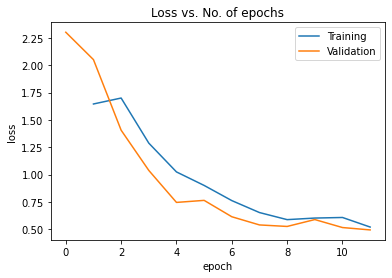

In [76]:
plot_losses(history)

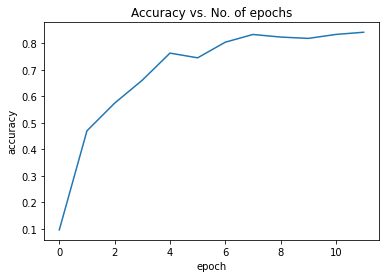

In [77]:
plot_accuracies(history)

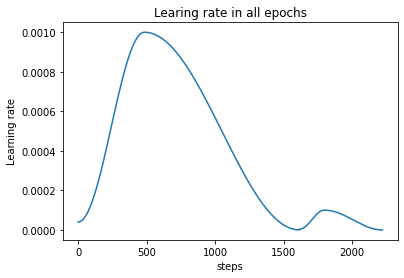

In [79]:
plot_learning_rates(history)

# Transfer Learning with ResNet34

We will train for one cycle with the convolution layers frozen and then fow two more cycles with all the layers unfrozen.

In [80]:
class Resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        #return torch.sigmoid(self.network(xb))
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [81]:
net = Resnet()
net = net.to(device)

history = [evaluate(net, valid_dataloader)]
history

[{'val_acc': 0.05138739198446274, 'val_loss': 2.697150945663452}]

**First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.**

In [82]:
net.freeze()

In [83]:
epochs = 5
max_lr = lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [84]:
%%time
history += fit_one_cycle(epochs, max_lr, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00076, train_loss: 0.5694, val_loss: 1.8051, val_acc: 0.6125



Epoch [1], last_lr: 0.00095, train_loss: 0.6291, val_loss: 0.7305, val_acc: 0.7813



Epoch [2], last_lr: 0.00061, train_loss: 0.4716, val_loss: 0.4045, val_acc: 0.8648



Epoch [3], last_lr: 0.00019, train_loss: 0.3037, val_loss: 0.2250, val_acc: 0.9380



Epoch [4], last_lr: 0.00000, train_loss: 0.1707, val_loss: 0.1646, val_acc: 0.9515
CPU times: user 4min 22s, sys: 2min 13s, total: 6min 36s
Wall time: 6min 51s


**Now, unfreeze and train some more.**

In [85]:
net.unfreeze()

In [87]:
%%time
history += fit_one_cycle(epochs, 4e-4, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00030, train_loss: 0.1785, val_loss: 0.3176, val_acc: 0.9036



Epoch [1], last_lr: 0.00038, train_loss: 0.3562, val_loss: 0.3278, val_acc: 0.8995



Epoch [2], last_lr: 0.00024, train_loss: 0.2819, val_loss: 0.2630, val_acc: 0.9181



Epoch [3], last_lr: 0.00008, train_loss: 0.1763, val_loss: 0.1845, val_acc: 0.9478



Epoch [4], last_lr: 0.00000, train_loss: 0.0985, val_loss: 0.1768, val_acc: 0.9498
CPU times: user 4min 21s, sys: 2min 12s, total: 6min 33s
Wall time: 6min 49s


In [92]:
%%time
history += fit_one_cycle(epochs, 5e-5, net, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00004, train_loss: 0.0838, val_loss: 0.1725, val_acc: 0.9578



Epoch [1], last_lr: 0.00005, train_loss: 0.0939, val_loss: 0.1796, val_acc: 0.9478



Epoch [2], last_lr: 0.00003, train_loss: 0.0716, val_loss: 0.2024, val_acc: 0.9456



Epoch [3], last_lr: 0.00001, train_loss: 0.0561, val_loss: 0.1965, val_acc: 0.9474



Epoch [4], last_lr: 0.00000, train_loss: 0.0449, val_loss: 0.1949, val_acc: 0.9515
CPU times: user 4min 21s, sys: 2min 12s, total: 6min 34s
Wall time: 6min 49s


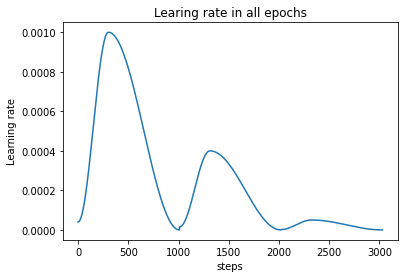

In [93]:
plot_learning_rates(history)

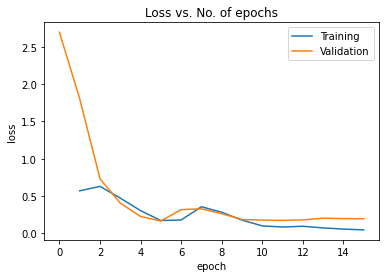

In [94]:
plot_losses(history)

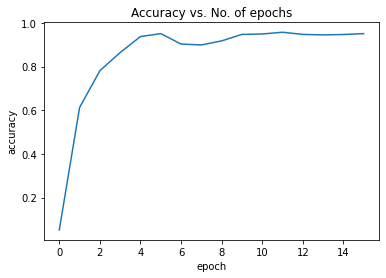

In [95]:
plot_accuracies(history)

# References:


1.   [fast.ai (Jeremy Howard)](https://www.fast.ai/)
2.   [fast.ai datasets](https://course.fast.ai/datasets)
3.   [Deep Learning with PyTorch: Zero to GANs](https://jovian.ml/forum/t/start-here-welcome-to-deep-learning-with-pytorch-zero-to-gans/1622)
4.   [How Do You Find A Good Learning Rate by Sylvain Gugger](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
5.   [Cyclical Learning Rates for Training Neural Networks, Leslie N. Smith](https://arxiv.org/abs/1506.01186)
6.   [Adaptive - and Cyclical Learning Rates using PyTorch](https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee)
7.   [Sebastian Raschka, STAT 453, University of Wisconsin-Madison]( https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mlp/mlp-dropout.ipynb)